# Reaction Template Visualization and Validation

This notebook visualizes atom mappings in chemical reactions governed by SMARTS templates.

**Use cases:**
- Inspect potentially promiscuous DORAnet reaction templates
- Validate that a template produces the expected products
- Visualize atom mappings to understand reaction mechanisms
- Calculate reaction enthalpy using pathermo

## 1. Setup and Imports

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdChemReactions
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, display, HTML
import re

# Import pathermo for thermodynamic calculations
try:
    from pathermo.properties import Hf as pathermo_Hf
    PATHERMO_AVAILABLE = True
    print("pathermo available for thermodynamic calculations")
except ImportError:
    pathermo_Hf = None
    PATHERMO_AVAILABLE = False
    print("pathermo not available - install with: pip install pathermo")

print("RDKit version:", Chem.rdBase.rdkitVersion)

pathermo available for thermodynamic calculations
RDKit version: 2023.09.6


## 2. Define Reaction and Template

**Example reaction:** Dehydration/elimination reaction
- Reactant: `COC(CO)CC(=O)O` (methoxy-hydroxy compound with carboxylic acid)
- Products: `C=C(C=C=O)OC` + `O` (alkene with ketene + water)

In [12]:
# Reaction SMILES: reactants >> products
REACTION_SMILES = "OC1C=CCCC1>>C1C=C=CCC1"

# Atom-mapped SMARTS template
# This template describes a double elimination forming two C=C bonds and releasing water
REACTION_TEMPLATE = "[C+0!H0:1]-[C+0:2]-[O+0H:3]>>[*:1]=[*:2].[*:3]"

print("Reaction SMILES:")
print(f"  {REACTION_SMILES}")
print(f"\nReaction Template:")
print(f"  {REACTION_TEMPLATE}")

Reaction SMILES:
  OC1C=CCCC1>>C1C=C=CCC1

Reaction Template:
  [C+0!H0:1]-[C+0:2]-[O+0H:3]>>[*:1]=[*:2].[*:3]


## 3. Parse and Display Reactants and Products

In [13]:
def parse_reaction_smiles(reaction_smiles):
    """
    Parse a reaction SMILES string into reactants and products.
    
    Args:
        reaction_smiles: String in format "A.B>>C.D"
    
    Returns:
        Tuple of (reactant_smiles_list, product_smiles_list)
    """
    if ">>" not in reaction_smiles:
        raise ValueError("Reaction SMILES must contain '>>'")
    
    reactants_str, products_str = reaction_smiles.split(">>")
    reactants = [s.strip() for s in reactants_str.split(".") if s.strip()]
    products = [s.strip() for s in products_str.split(".") if s.strip()]
    
    return reactants, products

reactant_smiles_list, product_smiles_list = parse_reaction_smiles(REACTION_SMILES)

print("Reactants:")
for i, smi in enumerate(reactant_smiles_list):
    mol = Chem.MolFromSmiles(smi)
    formula = Chem.rdMolDescriptors.CalcMolFormula(mol) if mol else "INVALID"
    print(f"  {i+1}. {smi} ({formula})")

print("\nProducts:")
for i, smi in enumerate(product_smiles_list):
    mol = Chem.MolFromSmiles(smi)
    formula = Chem.rdMolDescriptors.CalcMolFormula(mol) if mol else "INVALID"
    print(f"  {i+1}. {smi} ({formula})")

Reactants:
  1. OC1C=CCCC1 (C6H10O)

Products:
  1. C1C=C=CCC1 (C6H8)


Reactants:


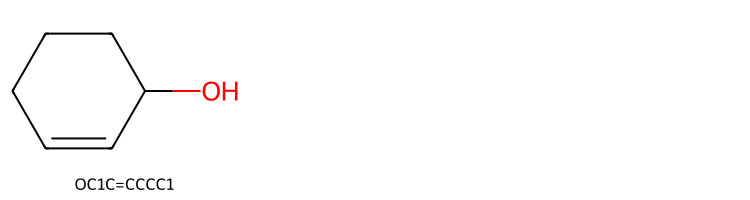


Products:


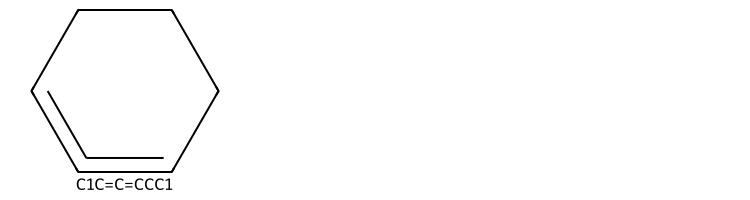

In [14]:
# Visualize reactants and products
reactant_mols = [Chem.MolFromSmiles(smi) for smi in reactant_smiles_list]
product_mols = [Chem.MolFromSmiles(smi) for smi in product_smiles_list]

print("Reactants:")
display(Draw.MolsToGridImage(reactant_mols, molsPerRow=3, subImgSize=(250, 200), 
                              legends=reactant_smiles_list))

print("\nProducts:")
display(Draw.MolsToGridImage(product_mols, molsPerRow=3, subImgSize=(250, 200),
                              legends=product_smiles_list))

## 4. Calculate Reaction Enthalpy (ΔH) using pathermo

The enthalpy of reaction is calculated as:

$$\Delta H_{rxn} = \sum H_f(products) - \sum H_f(reactants)$$

Where $H_f$ is the enthalpy of formation (kcal/mol) estimated using group contribution methods.

In [15]:
def calculate_enthalpy_of_formation(smiles):
    """
    Calculate enthalpy of formation for a molecule using pathermo.
    
    Args:
        smiles: SMILES string of the molecule
    
    Returns:
        Enthalpy of formation in kcal/mol, or None if calculation fails
    """
    if not PATHERMO_AVAILABLE or pathermo_Hf is None:
        return None
    try:
        hf = pathermo_Hf(smiles)
        return float(hf) if hf is not None else None
    except Exception as e:
        print(f"  Warning: Could not calculate Hf for {smiles}: {e}")
        return None


def calculate_reaction_enthalpy(reactant_smiles_list, product_smiles_list):
    """
    Calculate the enthalpy of reaction (ΔH) for a chemical reaction.
    
    Args:
        reactant_smiles_list: List of reactant SMILES
        product_smiles_list: List of product SMILES
    
    Returns:
        Tuple of (delta_H, reactant_Hf_dict, product_Hf_dict) or (None, None, None) if failed
    """
    if not PATHERMO_AVAILABLE:
        print("pathermo not available - cannot calculate reaction enthalpy")
        return None, None, None
    
    # Calculate Hf for reactants
    reactant_hf = {}
    reactant_sum = 0.0
    for smi in reactant_smiles_list:
        hf = calculate_enthalpy_of_formation(smi)
        reactant_hf[smi] = hf
        if hf is None:
            print(f"  Could not calculate Hf for reactant: {smi}")
            return None, None, None
        reactant_sum += hf
    
    # Calculate Hf for products
    product_hf = {}
    product_sum = 0.0
    for smi in product_smiles_list:
        hf = calculate_enthalpy_of_formation(smi)
        product_hf[smi] = hf
        if hf is None:
            print(f"  Could not calculate Hf for product: {smi}")
            return None, None, None
        product_sum += hf
    
    # ΔH = Σ Hf(products) - Σ Hf(reactants)
    delta_h = product_sum - reactant_sum
    
    return delta_h, reactant_hf, product_hf


# Calculate reaction enthalpy
print("="*60)
print("REACTION THERMODYNAMICS")
print("="*60)

delta_h, reactant_hf, product_hf = calculate_reaction_enthalpy(
    reactant_smiles_list, product_smiles_list
)

if delta_h is not None:
    print("\nEnthalpy of Formation (Hf):")
    print("  Reactants:")
    for smi, hf in reactant_hf.items():
        print(f"    {smi}: {hf:.2f} kcal/mol")
    
    print("  Products:")
    for smi, hf in product_hf.items():
        print(f"    {smi}: {hf:.2f} kcal/mol")
    
    print(f"\nReaction Enthalpy (ΔH): {delta_h:.2f} kcal/mol")
    
    # Interpret the result
    FEASIBILITY_THRESHOLD = 15.0  # kcal/mol
    if delta_h < 0:
        print(f"  → Exothermic reaction (thermodynamically favorable)")
    elif delta_h < FEASIBILITY_THRESHOLD:
        print(f"  → Mildly endothermic (may be feasible, ΔH < {FEASIBILITY_THRESHOLD} kcal/mol)")
    else:
        print(f"  → Highly endothermic (thermodynamically unfavorable, ΔH > {FEASIBILITY_THRESHOLD} kcal/mol)")
else:
    print("\nCould not calculate reaction enthalpy")

REACTION THERMODYNAMICS

Enthalpy of Formation (Hf):
  Reactants:
    OC1C=CCCC1: -39.54 kcal/mol
  Products:
    C1C=C=CCC1: 38.00 kcal/mol

Reaction Enthalpy (ΔH): 77.54 kcal/mol
  → Highly endothermic (thermodynamically unfavorable, ΔH > 15.0 kcal/mol)


## 5. Parse and Analyze the Reaction Template

In [16]:
def analyze_reaction_template(template_smarts):
    """
    Analyze a reaction SMARTS template and extract atom mapping information.
    """
    # Parse the reaction
    rxn = AllChem.ReactionFromSmarts(template_smarts)
    if rxn is None:
        raise ValueError(f"Could not parse reaction template: {template_smarts}")
    
    print(f"Number of reactant templates: {rxn.GetNumReactantTemplates()}")
    print(f"Number of product templates: {rxn.GetNumProductTemplates()}")
    
    # Extract atom mappings from reactants
    print("\nReactant template atom mappings:")
    for i, reactant in enumerate(rxn.GetReactants()):
        print(f"  Reactant {i+1}: {Chem.MolToSmarts(reactant)}")
        for atom in reactant.GetAtoms():
            map_num = atom.GetAtomMapNum()
            if map_num > 0:
                print(f"    Atom {atom.GetIdx()}: {atom.GetSymbol()} -> map #{map_num}")
    
    # Extract atom mappings from products
    print("\nProduct template atom mappings:")
    for i, product in enumerate(rxn.GetProducts()):
        print(f"  Product {i+1}: {Chem.MolToSmarts(product)}")
        for atom in product.GetAtoms():
            map_num = atom.GetAtomMapNum()
            if map_num > 0:
                print(f"    Atom {atom.GetIdx()}: {atom.GetSymbol()} -> map #{map_num}")
    
    return rxn

rxn = analyze_reaction_template(REACTION_TEMPLATE)

Number of reactant templates: 1
Number of product templates: 2

Reactant template atom mappings:
  Reactant 1: [C&+0&!H0:1]-[C&+0:2]-[O&+0&H1:3]
    Atom 0: C -> map #1
    Atom 1: C -> map #2
    Atom 2: O -> map #3

Product template atom mappings:
  Product 1: [*:1]=[*:2]
    Atom 0: * -> map #1
    Atom 1: * -> map #2
  Product 2: [*:3]
    Atom 0: * -> map #3


## 6. Visualize the Reaction Template

Reaction Template Visualization:
Template: [C+0!H0:1]-[C+0:2]-[O+0H:3]>>[*:1]=[*:2].[*:3]


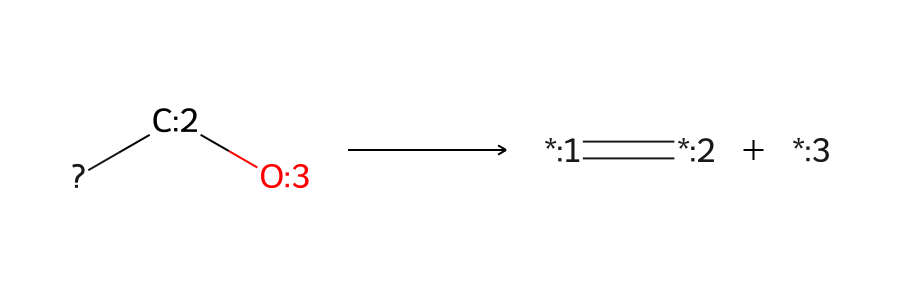

In [17]:
# Draw the reaction template with atom mappings
def draw_reaction_template(rxn, size=(900, 300)):
    """
    Draw a reaction template showing atom mappings.
    """
    drawer = rdMolDraw2D.MolDraw2DSVG(size[0], size[1])
    drawer.DrawReaction(rxn)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return SVG(svg)

print("Reaction Template Visualization:")
print(f"Template: {REACTION_TEMPLATE}")
display(draw_reaction_template(rxn))

## 7. Run the Reaction to Validate the Template

In [8]:
def run_reaction(template_smarts, reactant_smiles_list):
    """
    Run a reaction template on given reactants.
    
    Args:
        template_smarts: Reaction SMARTS template
        reactant_smiles_list: List of reactant SMILES strings
    
    Returns:
        List of product sets (each set is a tuple of product molecules)
    """
    rxn = AllChem.ReactionFromSmarts(template_smarts)
    if rxn is None:
        raise ValueError(f"Could not parse reaction template")
    
    # Convert SMILES to molecules
    reactant_mols = [Chem.MolFromSmiles(smi) for smi in reactant_smiles_list]
    if None in reactant_mols:
        raise ValueError("Could not parse one or more reactant SMILES")
    
    # Run the reaction
    # Note: reactants are passed as a tuple
    products_list = rxn.RunReactants(tuple(reactant_mols))
    
    return products_list

# Run the reaction
print("Running reaction...")
print(f"  Reactants: {reactant_smiles_list}")
print(f"  Template: {REACTION_TEMPLATE}")

try:
    products_list = run_reaction(REACTION_TEMPLATE, reactant_smiles_list)
    
    if products_list:
        print(f"\nReaction successful! Generated {len(products_list)} product set(s).")
        
        for i, product_set in enumerate(products_list):
            print(f"\nProduct set {i+1}:")
            for j, prod in enumerate(product_set):
                try:
                    Chem.SanitizeMol(prod)
                    prod_smiles = Chem.MolToSmiles(prod)
                    print(f"  Product {j+1}: {prod_smiles}")
                except Exception as e:
                    print(f"  Product {j+1}: [Sanitization failed: {e}]")
    else:
        print("\nNo products generated. Template may not match the reactants.")
        
except Exception as e:
    print(f"\nReaction failed: {e}")

Running reaction...
  Reactants: ['OC1C=CCCC1']
  Template: [C+0!H0:1][C+0:2][O+0H:3]>>[*:1]=[*:2].[*:3]

Reaction successful! Generated 2 product set(s).

Product set 1:
  Product 1: C1=CCCCC=1
  Product 2: O

Product set 2:
  Product 1: C1=CCCC=C1
  Product 2: O


## 8. Compare Generated Products with Expected Products

In [9]:
def canonicalize_smiles(smiles):
    """Convert SMILES to canonical form."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return Chem.MolToSmiles(mol, canonical=True)

# Expected products from the reaction SMILES
expected_products = set(canonicalize_smiles(smi) for smi in product_smiles_list)
print("Expected products (canonical):")
for smi in expected_products:
    print(f"  {smi}")

# Check if any generated product set matches
if products_list:
    print("\nChecking generated products against expected...")
    
    for i, product_set in enumerate(products_list):
        generated_products = set()
        for prod in product_set:
            try:
                Chem.SanitizeMol(prod)
                generated_products.add(Chem.MolToSmiles(prod, canonical=True))
            except:
                pass
        
        print(f"\nProduct set {i+1} (canonical): {generated_products}")
        
        if generated_products == expected_products:
            print("  MATCH! Generated products match expected products.")
        else:
            missing = expected_products - generated_products
            extra = generated_products - expected_products
            if missing:
                print(f"  Missing expected: {missing}")
            if extra:
                print(f"  Extra generated: {extra}")

Expected products (canonical):
  C1=CCCCC=1

Checking generated products against expected...

Product set 1 (canonical): {'O', 'C1=CCCCC=1'}
  Extra generated: {'O'}

Product set 2 (canonical): {'O', 'C1=CCCC=C1'}
  Missing expected: {'C1=CCCCC=1'}
  Extra generated: {'O', 'C1=CCCC=C1'}


## 9. Visualize Reactants with Atom Mappings

Reactant with atom mappings: C1=[CH:1][CH:2]([OH:3])CCC1

Reactant with mapped atoms highlighted:


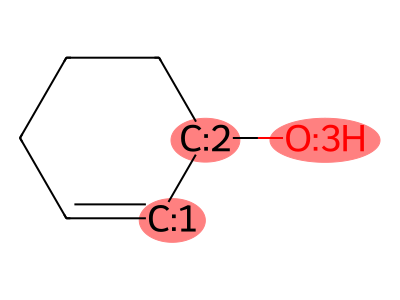


Reactant with atom mapping labels:


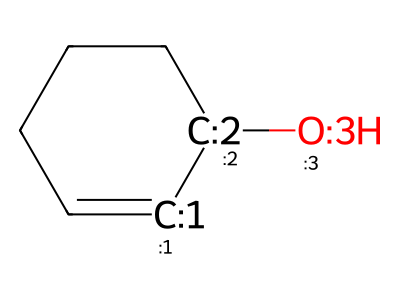

In [10]:
def add_atom_mappings_to_mol(mol, rxn_template, reactant_idx=0):
    """
    Add atom mapping numbers to a molecule based on a reaction template match.
    
    Returns a new molecule with atom map numbers set.
    """
    rxn = AllChem.ReactionFromSmarts(rxn_template)
    if rxn is None:
        return None
    
    # Get the reactant template
    if reactant_idx >= rxn.GetNumReactantTemplates():
        return None
    
    reactant_template = rxn.GetReactants()[reactant_idx]
    
    # Find matches
    matches = mol.GetSubstructMatches(reactant_template)
    
    if not matches:
        print(f"No match found for reactant template {reactant_idx}")
        return None
    
    # Use first match
    match = matches[0]
    
    # Create a copy and add atom mappings
    mol_copy = Chem.RWMol(mol)
    
    for template_atom_idx, mol_atom_idx in enumerate(match):
        template_atom = reactant_template.GetAtomWithIdx(template_atom_idx)
        map_num = template_atom.GetAtomMapNum()
        if map_num > 0:
            mol_copy.GetAtomWithIdx(mol_atom_idx).SetAtomMapNum(map_num)
    
    return mol_copy.GetMol()


def draw_mol_with_atom_labels(mol, size=(400, 300), title=""):
    """
    Draw a molecule with atom mapping labels shown.
    """
    mol_copy = Chem.RWMol(mol)
    # Add atom mapping numbers as labels
    for atom in mol_copy.GetAtoms():
        map_num = atom.GetAtomMapNum()
        if map_num > 0:
            atom.SetProp("atomNote", f":{map_num}")
    
    drawer = rdMolDraw2D.MolDraw2DSVG(size[0], size[1])
    drawer.drawOptions().addAtomIndices = False
    drawer.DrawMolecule(mol_copy.GetMol())
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    
    if title:
        print(title)
    return SVG(svg)


# Add atom mappings to the reactant
reactant_mol = Chem.MolFromSmiles(reactant_smiles_list[0])
mapped_reactant = add_atom_mappings_to_mol(reactant_mol, REACTION_TEMPLATE, reactant_idx=0)

if mapped_reactant:
    mapped_smiles = Chem.MolToSmiles(mapped_reactant)
    print(f"Reactant with atom mappings: {mapped_smiles}")
    
    # Highlight mapped atoms
    mapped_atoms = [atom.GetIdx() for atom in mapped_reactant.GetAtoms() if atom.GetAtomMapNum() > 0]
    
    print("\nReactant with mapped atoms highlighted:")
    display(Draw.MolToImage(mapped_reactant, size=(400, 300), highlightAtoms=mapped_atoms))
    
    print("\nReactant with atom mapping labels:")
    display(draw_mol_with_atom_labels(mapped_reactant))
else:
    print("Could not map atoms to reactant")

## 10. Visualize Products with Atom Mappings

The products from `RunReactants` retain atom mapping information from the template.

Products with atom mappings (from first product set):

Product 1: C1=CCCCC=1
  Atom mappings: None
  Product with mapped atoms highlighted:


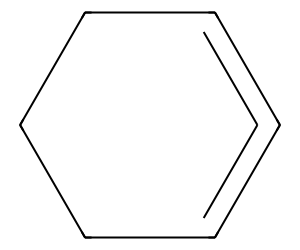

  Product with atom mapping labels:


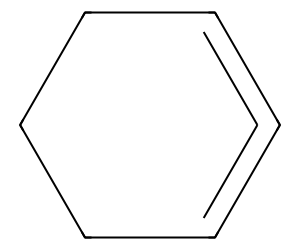


Product 2: O
  Atom mappings: None
  Product with mapped atoms highlighted:


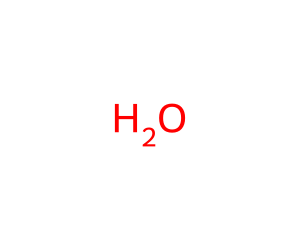

  Product with atom mapping labels:


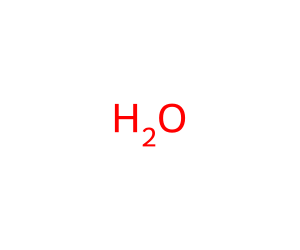

In [11]:
# Get products with atom mappings preserved
if products_list and len(products_list) > 0:
    print("Products with atom mappings (from first product set):")
    print("="*60)
    
    product_set = products_list[0]  # Use first product set
    
    for i, prod in enumerate(product_set):
        try:
            # Products from RunReactants have atom mappings preserved
            prod_smiles_mapped = Chem.MolToSmiles(prod)
            
            # Get atoms with mappings
            mapped_atoms = []
            atom_map_info = []
            for atom in prod.GetAtoms():
                map_num = atom.GetAtomMapNum()
                if map_num > 0:
                    mapped_atoms.append(atom.GetIdx())
                    atom_map_info.append(f"{atom.GetSymbol()}:{map_num}")
            
            print(f"\nProduct {i+1}: {prod_smiles_mapped}")
            print(f"  Atom mappings: {', '.join(atom_map_info) if atom_map_info else 'None'}")
            
            # Sanitize for display
            Chem.SanitizeMol(prod)
            
            # Display with highlighting
            print(f"  Product with mapped atoms highlighted:")
            display(Draw.MolToImage(prod, size=(300, 250), highlightAtoms=mapped_atoms))
            
            # Display with labels
            print(f"  Product with atom mapping labels:")
            display(draw_mol_with_atom_labels(prod, size=(300, 250)))
            
        except Exception as e:
            print(f"\nProduct {i+1}: [Error: {e}]")
else:
    print("No products available to display")

## 11. Side-by-Side Reaction Visualization

Full Reaction with Atom Mappings:


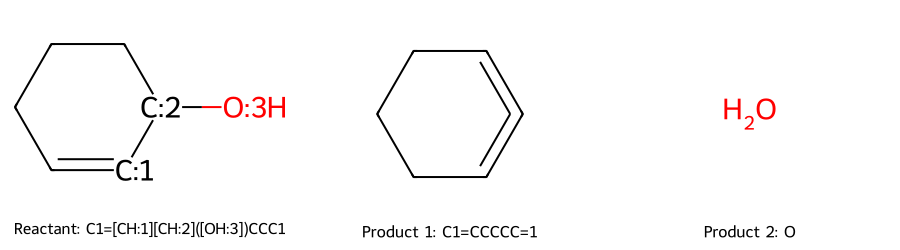


Atom mapping legend:
  :1, :2 -> C=C bond formation (first elimination)
  :3     -> Released as water (OH leaving group)
  :4, :5 -> C=C bond formation (second elimination)


In [18]:
# Create a side-by-side visualization showing atom mappings
if mapped_reactant and products_list and len(products_list) > 0:
    print("Full Reaction with Atom Mappings:")
    print("="*60)
    
    # Collect all molecules for display
    all_mols = [mapped_reactant]
    legends = [f"Reactant: {Chem.MolToSmiles(mapped_reactant)}"]
    
    product_set = products_list[0]
    for i, prod in enumerate(product_set):
        try:
            Chem.SanitizeMol(prod)
            all_mols.append(prod)
            legends.append(f"Product {i+1}: {Chem.MolToSmiles(prod)}")
        except:
            pass
    
    # Display grid
    display(Draw.MolsToGridImage(all_mols, molsPerRow=3, subImgSize=(300, 250), 
                                  legends=legends))
    
    print("\nAtom mapping legend:")
    print("  :1, :2 -> C=C bond formation (first elimination)")
    print("  :3     -> Released as water (OH leaving group)")
    print("  :4, :5 -> C=C bond formation (second elimination)")

## 12. Complete Analysis Function

In [19]:
def analyze_and_visualize_reaction(reaction_smiles, template_smarts):
    """
    Complete analysis and visualization of a reaction with its template.
    
    Args:
        reaction_smiles: Reaction in format "A.B>>C.D"
        template_smarts: Atom-mapped SMARTS template
    """
    print("="*70)
    print("REACTION TEMPLATE ANALYSIS")
    print("="*70)
    
    # Parse reaction
    reactants, products = parse_reaction_smiles(reaction_smiles)
    
    print(f"\nReaction: {reaction_smiles}")
    print(f"Template: {template_smarts}")
    
    print(f"\nReactants ({len(reactants)}):")
    for smi in reactants:
        mol = Chem.MolFromSmiles(smi)
        formula = Chem.rdMolDescriptors.CalcMolFormula(mol) if mol else "INVALID"
        print(f"  {smi} ({formula})")
    
    print(f"\nExpected Products ({len(products)}):")
    for smi in products:
        mol = Chem.MolFromSmiles(smi)
        formula = Chem.rdMolDescriptors.CalcMolFormula(mol) if mol else "INVALID"
        print(f"  {smi} ({formula})")
    
    # Calculate thermodynamics
    print("\n" + "-"*70)
    print("THERMODYNAMICS")
    print("-"*70)
    
    delta_h, reactant_hf, product_hf = calculate_reaction_enthalpy(reactants, products)
    if delta_h is not None:
        print(f"\nΔH = {delta_h:.2f} kcal/mol")
        if delta_h < 0:
            print("  → Exothermic (favorable)")
        elif delta_h < 15:
            print("  → Mildly endothermic (may be feasible)")
        else:
            print("  → Highly endothermic (unfavorable)")
    else:
        print("\nCould not calculate ΔH")
    
    # Parse and visualize template
    print("\n" + "-"*70)
    print("TEMPLATE STRUCTURE")
    print("-"*70)
    
    rxn = AllChem.ReactionFromSmarts(template_smarts)
    if rxn is None:
        print("ERROR: Could not parse template!")
        return
    
    print(f"\nReactant templates: {rxn.GetNumReactantTemplates()}")
    print(f"Product templates: {rxn.GetNumProductTemplates()}")
    
    display(draw_reaction_template(rxn))
    
    # Run reaction
    print("\n" + "-"*70)
    print("REACTION VALIDATION")
    print("-"*70)
    
    try:
        products_list = run_reaction(template_smarts, reactants)
        
        if products_list:
            print(f"\nGenerated {len(products_list)} product set(s)")
            
            expected_set = set(canonicalize_smiles(smi) for smi in products)
            
            match_found = False
            for i, product_set in enumerate(products_list):
                generated_set = set()
                product_smiles_for_display = []
                
                for prod in product_set:
                    try:
                        Chem.SanitizeMol(prod)
                        smi = Chem.MolToSmiles(prod, canonical=True)
                        generated_set.add(smi)
                        product_smiles_for_display.append(smi)
                    except Exception as e:
                        product_smiles_for_display.append(f"[Error: {e}]")
                
                print(f"\nProduct set {i+1}: {product_smiles_for_display}")
                
                if generated_set == expected_set:
                    print("  ✓ MATCHES expected products!")
                    match_found = True
                else:
                    missing = expected_set - generated_set
                    extra = generated_set - expected_set
                    if missing:
                        print(f"  Missing: {missing}")
                    if extra:
                        print(f"  Extra: {extra}")
            
            if not match_found:
                print("\n⚠ WARNING: No product set exactly matches expected products!")
            
            # Show atom mappings on products
            print("\n" + "-"*70)
            print("ATOM MAPPINGS ON PRODUCTS")
            print("-"*70)
            
            product_set = products_list[0]
            for j, prod in enumerate(product_set):
                try:
                    atom_maps = [(a.GetSymbol(), a.GetAtomMapNum()) for a in prod.GetAtoms() if a.GetAtomMapNum() > 0]
                    print(f"\nProduct {j+1} mappings: {atom_maps}")
                    Chem.SanitizeMol(prod)
                    display(draw_mol_with_atom_labels(prod, size=(250, 200)))
                except Exception as e:
                    print(f"Product {j+1}: Error - {e}")
                    
        else:
            print("\n✗ No products generated - template does not match reactants!")
            
    except Exception as e:
        print(f"\n✗ Reaction failed: {e}")
    
    print("\n" + "="*70)

REACTION TEMPLATE ANALYSIS

Reaction: OC1C=CCCC1>>C1C=C=CCC1
Template: [C+0!H0:1]-[C+0:2]-[O+0H:3]>>[*:1]=[*:2].[*:3]

Reactants (1):
  OC1C=CCCC1 (C6H10O)

Expected Products (1):
  C1C=C=CCC1 (C6H8)

----------------------------------------------------------------------
THERMODYNAMICS
----------------------------------------------------------------------

ΔH = 77.54 kcal/mol
  → Highly endothermic (unfavorable)

----------------------------------------------------------------------
TEMPLATE STRUCTURE
----------------------------------------------------------------------

Reactant templates: 1
Product templates: 2


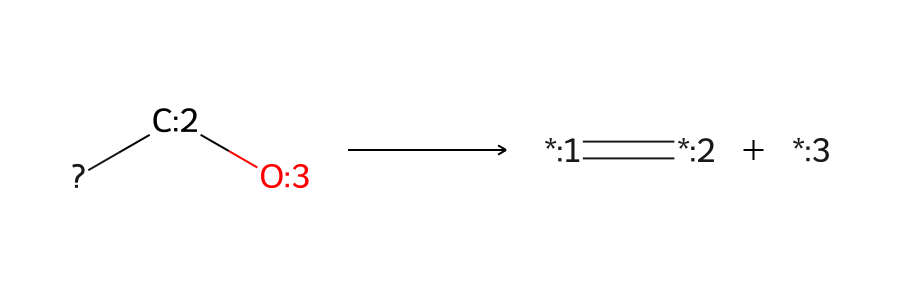


----------------------------------------------------------------------
REACTION VALIDATION
----------------------------------------------------------------------

Generated 2 product set(s)

Product set 1: ['C1=CCCCC=1', 'O']
  Extra: {'O'}

Product set 2: ['C1=CCCC=C1', 'O']
  Missing: {'C1=CCCCC=1'}
  Extra: {'O', 'C1=CCCC=C1'}

⚠ WARNING: No product set exactly matches expected products!

----------------------------------------------------------------------
ATOM MAPPINGS ON PRODUCTS
----------------------------------------------------------------------

Product 1 mappings: []


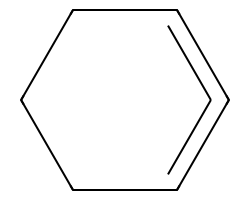


Product 2 mappings: []


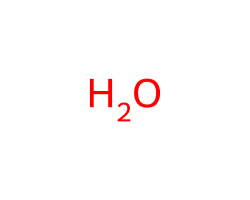

In [20]:
# Run the full analysis on our example
analyze_and_visualize_reaction(REACTION_SMILES, REACTION_TEMPLATE)

## 13. Test with Additional Reactions

Use this cell to test other suspicious DORAnet reactions.

In [ ]:
# Example: Test another reaction
# Uncomment and modify to test:

# test_reaction = "your_reaction_smiles_here"
# test_template = "your_template_here"
# analyze_and_visualize_reaction(test_reaction, test_template)